# **Data Sprint #6: <a href="https://dphi.tech/practice/challenge/37">Face Mask Detection</a>**

---
Dataset <a href="https://drive.google.com/file/d/1_W2gFFZmy6ZyC8TPlxB49eDFswdBsQqo/view?usp=sharing">Link</a>


## Download the images

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1_W2gFFZmy6ZyC8TPlxB49eDFswdBsQqo',
                                    dest_path='content/face_mask_detection.zip',
                                    unzip=True)

## **Import all the libraries**

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
%load_ext tensorboard

# Helper libraries
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from imutils import paths
from sklearn.utils import class_weight, shuffle
from tqdm import tqdm_notebook as tqdm
import argparse

#Deep Learning Tool
import os                                               # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set

print(tf.__version__)

2.3.0


## Loading and preparing training data
The train and test images are given in two different folders - 'train' and 'test'. The labels of train images are given in a csv file 'Training_set_face_mask.csv' with respective image id (i.e. image file name).

#### Getting the labels of the images

In [3]:
labels = pd.read_csv("/content/content/face_mask_detection/Training_set_face_mask.csv")   # loading the labels
labels.head()           # will display the first five rows in labels dataframe

,filename,label
0,Image_1.jpg,without_mask
1,Image_2.jpg,without_mask
2,Image_3.jpg,without_mask
3,Image_4.jpg,without_mask
4,Image_5.jpg,without_mask


In [4]:
labels.tail()            # will display the last five rows in labels dataframe

,filename,label
11259,Image_11260.jpg,with_mask
11260,Image_11261.jpg,with_mask
11261,Image_11262.jpg,with_mask
11262,Image_11263.jpg,with_mask
11263,Image_11264.jpg,with_mask


#### Getting images file path

In [5]:
file_paths = [[fname, '/content/content/face_mask_detection/train/' + fname] for fname in labels['filename']]

#### Confirming if no. of labels is equal to no. of images

In [6]:
# Confirm if number of images is same as number of labels given
if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  11264 matches the number of filenames i.e.  11264


#### Converting the file_paths to dataframe

In [7]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,/content/content/face_mask_detection/train/Ima...
1,Image_2.jpg,/content/content/face_mask_detection/train/Ima...
2,Image_3.jpg,/content/content/face_mask_detection/train/Ima...
3,Image_4.jpg,/content/content/face_mask_detection/train/Ima...
4,Image_5.jpg,/content/content/face_mask_detection/train/Ima...


#### Combining the labels with the images

In [8]:
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head() 

,filename,filepaths,label
0,Image_1.jpg,/content/content/face_mask_detection/train/Ima...,without_mask
1,Image_2.jpg,/content/content/face_mask_detection/train/Ima...,without_mask
2,Image_3.jpg,/content/content/face_mask_detection/train/Ima...,without_mask
3,Image_4.jpg,/content/content/face_mask_detection/train/Ima...,without_mask
4,Image_5.jpg,/content/content/face_mask_detection/train/Ima...,without_mask


The 'train_data' dataframe contains all the image id, their locations and their respective labels. Now the training data is ready.

## **Data Pre-processing**

### Perform One hot Encoding on the labels

In [9]:
lb = LabelBinarizer()
labels_bin = lb.fit_transform(train_data.label) # categorical labels to binary
train_data["labels_bin"] = lb.fit_transform(train_data.label) # categorical labels to binary
labels_OHE =  to_categorical(labels_bin)  # One-Hot-Encoding for the labels binary

In [10]:
train_data.head()

,filename,filepaths,label,labels_bin
0,Image_1.jpg,/content/content/face_mask_detection/train/Ima...,without_mask,1
1,Image_2.jpg,/content/content/face_mask_detection/train/Ima...,without_mask,1
2,Image_3.jpg,/content/content/face_mask_detection/train/Ima...,without_mask,1
3,Image_4.jpg,/content/content/face_mask_detection/train/Ima...,without_mask,1
4,Image_5.jpg,/content/content/face_mask_detection/train/Ima...,without_mask,1


### Shuffling input and target for optimum training

In [11]:
x = train_data['filepaths']
y = train_data['labels_bin']

x, y = shuffle(x, y, random_state=8)

### Function for Resizing and Reshaping the input images

In [12]:
def centering_image(img):
    
    size = [256,256]
    #shape:(h×w×t)taking the first2 elements(h,w) and unpacking them appropriately 
    img_size = img.shape[:2]
    
    # extracting the excess space for centering.
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    
    #creating centered image by taking a 0-matrix and then re-assigning intensities
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

### Image Resizing and converting them to array

In [13]:
images = []
with tqdm(total=len(train_data)) as pbar:
    for i, file_path in enumerate(train_data.filepaths.values):
        
        #read image
        img = cv2.imread(file_path,1)
        #color order is changed
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize
        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


### Re-Shuffling processed train data and converting to array

In [14]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

### Train val split, OneHotVectorizing categories, Input normalization

---

Train val split partition the data into training and testing splits using 80% of
the data for training and the remaining 20% for testing

In [15]:
val_split_num = int(round(0.2*len(y)))

x_train = x[val_split_num:]
y_train = y[val_split_num:]

x_validation = x[:val_split_num]
y_validation = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('--------------------------')
print('x_test', x_validation.shape)
print('y_test', y_validation.shape)

# OneHotVectorizing categories
y_train = to_categorical(y_train)
y_validation = to_categorical(y_validation)

# Input normalization
x_train = x_train.astype('float32')
x_validation = x_validation.astype('float32')

x_train /= 255
x_validation /= 255

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_validation.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_validation.shape)
print('image Shape:', x_train[0].shape)

x_train (9011, 224, 224, 3)
y_train (9011,)
--------------------------
x_test (2253, 224, 224, 3)
y_test (2253,)
x_train Shape: (9011, 224, 224, 3) 	 x_test Shape: (2253, 224, 224, 3)
y_train Shape:  (9011, 2) 	 y_test Shape: (2253, 2)
image Shape: (224, 224, 3)


### Construct the training Image Generator for Data Augmentation

In [16]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

## Building the Model using MobileNetV2

### Initialize the initial learning rate, number of epochs to train for, and batch size

In [17]:
INIT_LR = 1e-5
EPOCHS = 5
BS = 32

### Load the MobileNetV2 network, ensuring the head FC layer sets are left off

In [18]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

### Construct the head of the model that will be placed on top of the base model

In [19]:
headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

### Place the head FC model on top of the base model

---


this will become the actual model we will train

In [20]:
model = Model(inputs=baseModel.input, outputs=headModel)

### Compile & Summary the model

In [21]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

### Train the head of the network

In [22]:
es_callback = EarlyStopping(monitor='val_loss', patience=3, 
                                               restore_best_weights=True,
                                               verbose=2)

In [23]:
H = model.fit(
	aug.flow(x_train, y_train, batch_size=BS), callbacks=[es_callback],
	steps_per_epoch=len(x_train) // BS,
  validation_data=(x_validation, y_validation),
	validation_steps=len(x_validation) // BS,
	epochs=EPOCHS)

Epoch 1/5
281/281 [==============================] - 2040s 7s/step - loss: 1.0108 - accuracy: 0.7853 - val_loss: 0.2584 - val_accuracy: 0.9028
Epoch 2/5
281/281 [==============================] - 2023s 7s/step - loss: 0.3296 - accuracy: 0.9092
Epoch 3/5
281/281 [==============================] - 2027s 7s/step - loss: 0.1988 - accuracy: 0.9420
Epoch 4/5
281/281 [==============================] - 2032s 7s/step - loss: 0.1366 - accuracy: 0.9589
Epoch 5/5
281/281 [==============================] - 2015s 7s/step - loss: 0.1222 - accuracy: 0.9606


In [24]:
H.history

{'accuracy': [0.7852767705917358,
  0.9092326760292053,
  0.9419757127761841,
  0.9589040875434875,
  0.9605746865272522],
 'loss': [1.0107659101486206,
  0.32956981658935547,
  0.1988043487071991,
  0.13659889996051788,
  0.1222224161028862],
 'val_accuracy': [0.9027962684631348],
 'val_loss': [0.258394330739975]}

### Plot the training loss and accuracy

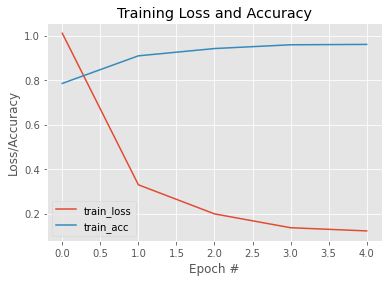

In [25]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [27]:
# make predictions on the testing set
print("evaluating network...")
predIdxs = model.predict(x_validation, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(y_validation.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

evaluating network...
              precision    recall  f1-score   support

   with_mask       0.95      0.99      0.97      1109
without_mask       0.99      0.95      0.97      1144

    accuracy                           0.97      2253
   macro avg       0.97      0.97      0.97      2253
weighted avg       0.97      0.97      0.97      2253



## Convert the model.

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpwpzl7e2n/assets


In [29]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)